In [9]:
%matplotlib inline

import geopandas
from shapely.geometry import Polygon
from shapely.geometry import box
from shapely.affinity import translate
from shapely.affinity import rotate
from shapely.ops import unary_union

from copy import deepcopy
import math

# Triangular weave
This code will make a diamond shaped unit that can be tiled to make a triangular weave pattern.

In [71]:
class Triangular_Weave():
    
    self.translations = {
        "e": (1, 0), 
        "ne": (0.5, math.sqrt(3) / 2),
        "se": (0.5, -math.sqrt(3) / 2)
    }

    """
    Class to store the properties of a triangular weave tile that can be repeated in a diamond
    pattern.

    Members
    -------
        w_ew: width of the horizontal ribbons
        s_ew
        w_swne: width of the upward left to right ribbons
        s_swne
        w_nwse: width of the downward left to right ribbons
        s_nwse 
        shapes: a list of rectangular shapely.geometry.Polygons forming the weave
        labels: a list of labels in the same order as the shapes
        tile_box: a diamond Polygon that exactly contains the primitive cell
        margin: inset margin on the shapes in the weave
    """
    def __init__(self, 
                 w_ew=1, s_ew=3, 
                 w_swne=1, s_swne=3, 
                 w_nwse=1, s_nwse=3, 
                 labels_ew=["ew1"], labels_swne =["swne1"], labels_nwse = ["nwse1"], 
                 margin = 0):
        """
        Class constructor, parameters as above except:
        labelsh: labels of the horizontal ribbons
        labelsv: labels of the vertical ribbons
        """
        self.w_ew = w_ew
        self.s_ew = s_ew
        self.w_swne = w_swne
        self.s_swne = s_swne
        self.w_nwse = w_nwse
        self.s_nwse = s_nwse
        self.tile_box = self.get_tile_box(labels_ew, labels_swne, labels_nwse)
        self.shapes, self.labels = self.get_shapes_and_labels(labels_ew, labels_swne, labels_nwse, margin)
        
    
    def get_shapes_and_labels(self, labels_ew, labels_swne, labels_nwse, m):
        """
        Returns the list of shapes and labels
        """
        W = math.sqrt(3) / 2
        
        # length of the ribbons calculated from 
        # the spacing and width of other directions
        l_ew = self.s_nwse - self.w_nwse
        l_swne = self.s_ew - self.w_ew
        l_nwse = self.s_swne - self.w_swne
        
        # base parallelograms
        base_ew = Polygon([(0, 0), (l_ew, 0), (l_ew - l_ew / 4, self.w_ew * W), (-l_ew / 4, self.w_ew * W)])
        base_swne = rotate(deepcopy(base_ew), -120, (0, 0))
        base_nwse = rotate(deepcopy(base_ew), 120, (0, 0))
        base_ew_2 = translate(deepcopy(base_ew), -3 * l_ew / 4, -self.s_ew * W)
        base_nwse_2 = translate(deepcopy(base_nwse), 3 * l_ew / 4, -self.s_ew * W)
        
        shps = [base_ew, base_swne, base_nwse, base_ew_2, base_nwse_2]
        lbls = [labels_ew[0], labels_swne[0], labels_nwse[0], labels_ew[0], labels_nwse[0]]
        shapes = []
        labels = []
        for p, l in zip(shps, lbls):
            if self.tile_box.intersects(p):
                shapes.append(p.intersection(self.tile_box))
                labels.append(l)
        return (shapes, labels)
        
        
    def get_tile_box(self, labels_ew, labels_swne, labels_nwse):
        """
        Bounding polygon is a diamond with dimensions dependendent on the spacings and numbers of ribbons
        """
        # here the number of ribbons in each direction is
        # just the length of the label lists
        n_ew = len(labels_ew)
        n_swne = max(n_ew, len(labels_swne))
        n_nwse = max(n_ew, len(labels_nwse))
        pts = [(-n_ew * 3 / 2, -math.sqrt(3) / 2)]
        bearings = [math.pi / 3 * n for n in [-1, 1, 2]]
        for i in range(1, 4):
            ang = bearings[i - 1]
            pts.append((pts[i - 1][0] + n_swne * self.s_swne * math.cos(ang),
                        pts[i - 1][1] + n_swne * self.s_swne * math.sin(ang)))
        return Polygon(pts)
    

    def get_primitive_cell(self):
        """
        Make and return a Primitive_Cell from the shapes and bounding shape
        """
        c_bb = self.tile_box.centroid
        c_unit = unary_union(self.shapes).centroid
        types = ["bounding_polygon"]
        shapes = [self.tile_box]
        labels = ["bb"]
        for s, label in zip(w.shapes, w.labels):
            if s.intersects(self.tile_box):
                shapes.append(s.intersection(self.tile_box))
                labels.append(label)
                types.append("shape")
        return geopandas.GeoDataFrame(data = {"label": labels, "type": types},
                                      geometry = geopandas.GeoSeries(shapes))

In [73]:
w = Triangular_Weave()
tile = w.get_primitive_cell()

<AxesSubplot:>

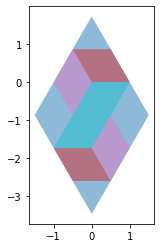

In [75]:
tile.plot(column = "label", alpha = 0.5)

In [74]:
tile.to_file("tile.geojson", driver = "GeoJSON")

## Possible tiling code
But this is hard to use and MMGIS does the needful anyway.

Won't work with updated `Weave` class... due to the extra 'buffer' polygons.

In [ ]:
def tile(w, minx = -30, miny = -30, maxx = 30, maxy = 30, rotation = 0):
    tiling_w = maxx - minx
    tiling_h = maxy - miny
    bb = unary_union(w.shapes).bounds
    width = bb[2] - bb[0]
    height = bb[3] - bb[1]
    repeats_h = math.ceil(tiling_w / width)
    repeats_v = math.ceil(tiling_h / height)
    total_w = repeats_h * width
    total_h = repeats_v * height
    origin_offset_x = (minx - (total_w - tiling_w) / 2) - bb[0]
    origin_offset_y = (miny - (total_h - tiling_h) / 2) - bb[1]
    template = []
    for s in deepcopy(w.shapes):
        template.append(translate(s, origin_offset_x, origin_offset_y))
    shapes = []
    for col in range(repeats_h):
        for row in range(repeats_v):
            for t in template:
                shapes.append(translate(deepcopy(t), w.dx * col, w.dy * row))
    labels = w.labels * (repeats_h * repeats_v)
    return geopandas.GeoDataFrame(data = {"label": labels}, geometry = geopandas.GeoSeries(shapes))

In [180]:
t = tile(w)

<AxesSubplot:>

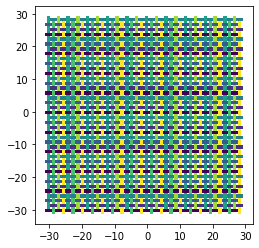

In [181]:
t.plot(column = "label")

In [178]:
t.to_file("weave.gpkg", driver = "GPKG")

In [48]:
gdf.geometry

0    POLYGON ((-1.50000 -0.50000, 1.50000 -0.50000,...
1    POLYGON ((0.50000 -0.50000, 3.50000 -0.50000, ...
2    POLYGON ((-0.50000 0.50000, 2.50000 0.50000, 2...
3    POLYGON ((-0.50000 0.50000, 2.50000 0.50000, 2...
Name: geometry, dtype: geometry

In [62]:
str(5)

'5'

In [43]:
max(1, 2, 3)

3